# Кейс

Представьте, что вы работаете DS в компании TripAdvisor. Одна из проблем компании — это нечестные рестораны, которые накручивают себе рейтинг. Одним из способов нахождения таких ресторанов является построение модели, которая предсказывает рейтинг ресторана. Если предсказания модели сильно отличаются от фактического результата, то, возможно, ресторан играет нечестно, и его стоит проверить.

# import

In [313]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import datetime
from datetime import datetime
import re

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [314]:
# Фиксируем RANDOM_SEED, чтобы эксперимент был воспроизводим
RANDOM_SEED = 42

In [315]:
# Зафиксируем ради воспроизводимости экспериментов и версию пакетов
!pip freeze > requirements.txt

# DATA

In [316]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [317]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [318]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [319]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [320]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [321]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [322]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [323]:
# ВАЖНО! для корректной обработки признаков объединяем train и test в один датасет
df_train['sample'] = 1 # помечаем тренировочные данные
df_test['sample'] = 0 # помечаем тестовые данные

# В тестовых данных нет значений Rating, их необходимо будет предсказать, поэтому пока заполняем нулями
df_test['Rating'] = 0 

# Объединяем датасеты
data = df_test.append(df_train, sort=False).reset_index(drop=True) 

In [324]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


## Подробности о признаках:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [325]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
44059,id_2547,Milan,"['Italian', 'Mediterranean', 'Seafood']",2549.0,$$$$,73.0,"[['Expensive and the quality is not there!', '...",/Restaurant_Review-g187849-d7251465-Reviews-Ar...,d7251465,1,4.0
25682,id_1870,Paris,"['American', 'Vegetarian Friendly']",1871.0,$$ - $$$,169.0,"[['Very good Burger!', 'Rude people but good b...",/Restaurant_Review-g187147-d8853097-Reviews-Bi...,d8853097,1,4.0
28021,id_1563,Stockholm,['International'],1566.0,$$ - $$$,12.0,"[['Lovely location, mediocre food', 'Nice rest...",/Restaurant_Review-g189852-d2341788-Reviews-Re...,d2341788,1,3.5
46355,id_4298,Berlin,['German'],4300.0,$,10.0,"[['Cooking course are overcrowded'], ['11/06/2...",/Restaurant_Review-g187323-d6508151-Reviews-Ko...,d6508151,1,4.0
19283,id_2754,Paris,"['Italian', 'Mediterranean']",2755.0,$$ - $$$,67.0,"[['A great family place', 'Great pasta and piz...",/Restaurant_Review-g187147-d5937609-Reviews-Da...,d5937609,1,4.5


In [326]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

In [327]:
# Переименуем столбцы
data.columns = ['local_id', 'city', 'cuisine', 'ranking', 'prices', 'reviews_number', 'reviews', 'ta_url', 'ta_id', 'sample', 'rating']

In [328]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
local_id          50000 non-null object
city              50000 non-null object
cuisine           38410 non-null object
ranking           50000 non-null float64
prices            32639 non-null object
reviews_number    46800 non-null float64
reviews           49998 non-null object
ta_url            50000 non-null object
ta_id             50000 non-null object
sample            50000 non-null int64
rating            50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [329]:
data.nunique(dropna=False)

local_id          13094
city                 31
cuisine           10732
ranking           12975
prices                4
reviews_number     1574
reviews           41858
ta_url            49963
ta_id             49963
sample                2
rating               10
dtype: int64

In [330]:
data[data.ta_id.duplicated(keep = False)]

,local_id,city,cuisine,ranking,prices,reviews_number,reviews,ta_url,ta_id,sample,rating
118,id_118,Warsaw,['Italian'],1801.0,$,3.0,"[[], []]",/Restaurant_Review-g274856-d10316215-Reviews-B...,d10316215,0,0.0
704,id_704,Madrid,NaN,6274.0,NaN,21.0,"[[], []]",/Restaurant_Review-g187514-d5617412-Reviews-Gr...,d5617412,0,0.0
1171,id_1171,Madrid,"['Indian', 'Asian', 'Nepali', 'Vegetarian Frie...",1219.0,$$ - $$$,22.0,"[['Fantastic food, Excellent service', 'Surpri...",/Restaurant_Review-g187514-d12488993-Reviews-K...,d12488993,0,0.0
1423,id_1423,Madrid,"['Chinese', 'Japanese', 'Sushi', 'Asian', 'Tha...",1220.0,$$ - $$$,159.0,"[['Excellent cuisine, friendly and helpful se....",/Restaurant_Review-g187514-d2010743-Reviews-Re...,d2010743,0,0.0
2654,id_2654,Madrid,"['Chinese', 'Japanese', 'Asian']",3146.0,$$ - $$$,53.0,"[['Excellent food food', 'Fantastic sushi serv...",/Restaurant_Review-g187514-d4914988-Reviews-Xi...,d4914988,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
46934,id_3140,Madrid,"['Japanese', 'Sushi', 'Asian', 'Thai']",3142.0,$$ - $$$,77.0,"[['Great Asian Option', 'Wow'], ['10/16/2017',...",/Restaurant_Review-g187514-d2360290-Reviews-Lo...,d2360290,1,3.5
48946,id_3242,Madrid,NaN,3244.0,NaN,13.0,"[[], []]",/Restaurant_Review-g187514-d10047799-Reviews-E...,d10047799,1,5.0
48967,id_1238,Madrid,"['Indian', 'Asian', 'Nepali', 'Vegetarian Frie...",1240.0,$$ - $$$,22.0,"[['Fantastic food, Excellent service', 'Surpri...",/Restaurant_Review-g187514-d12488993-Reviews-K...,d12488993,1,5.0
49797,id_3001,Madrid,"['Diner', 'Mediterranean', 'Spanish', 'Bar']",3003.0,$,71.0,"[['Very cozy!', 'Service rate: 1'], ['01/17/20...",/Restaurant_Review-g187514-d3647024-Reviews-La...,d3647024,1,3.5


In [331]:
data.reviews[118]

'[[], []]'

In [332]:
data[data.ta_id == 'd2010743']

,local_id,city,cuisine,ranking,prices,reviews_number,reviews,ta_url,ta_id,sample,rating
1423,id_1423,Madrid,"['Chinese', 'Japanese', 'Sushi', 'Asian', 'Tha...",1220.0,$$ - $$$,159.0,"[['Excellent cuisine, friendly and helpful se....",/Restaurant_Review-g187514-d2010743-Reviews-Re...,d2010743,0,0.0
13438,id_1198,Madrid,"['Chinese', 'Japanese', 'Sushi', 'Asian', 'Tha...",1199.0,$$ - $$$,156.0,"[['Excellent cuisine, friendly and helpful se....",/Restaurant_Review-g187514-d2010743-Reviews-Re...,d2010743,1,4.0


### Side Note
Похоже, что 37 ресторанов попали и в тестовые, и в тренировочные данные, так что в качестве дополнительной хитрости можно попробовать взять в качестве рейтинга тестовых данных значение рейтинга в тренировочных. Впрочем, это вряд ли сильно повлияет на МАЕ, к тому же данные несколько отличаются и рейтинг тоже мог измениться.

## Обработка NaN 
У наличия пропусков могут быть разные причины, но для работы модели нам потребуется их заполнить.
Иногда **даже отсутствие информации может оказаться важным признаком!**   
По этому перед обработкой NaN можно вынести информацию о наличии пропуска как отдельный признак.

In [333]:
# Начнём с reviews_number
data['rn_is_nan'] = pd.isna(data['reviews_number']).astype('uint8')

In [334]:
# Заполним пропуски
data['reviews_number'].fillna(1, inplace=True)

In [335]:
# Разберёмся с тегами, описывающими кухню заведения
data['cuisine'].fillna("['Unknown']", inplace=True)

In [336]:
data[data.reviews.isnull()]

,local_id,city,cuisine,ranking,prices,reviews_number,reviews,ta_url,ta_id,sample,rating,rn_is_nan
8168,id_8168,Lisbon,['Unknown'],3389.0,NaN,2.0,NaN,/Restaurant_Review-g189158-d12683988-Reviews-O...,d12683988,0,0.0,0
9608,id_9608,Vienna,['Unknown'],1779.0,NaN,1.0,NaN,/Restaurant_Review-g190454-d12605368-Reviews-R...,d12605368,0,0.0,1


In [337]:
data[data.reviews.isnull()].ta_url[8168]

'/Restaurant_Review-g189158-d12683988-Reviews-O_Sitar-Lisbon_Lisbon_District_Central_Portugal.html'

In [338]:
# Не похоже, что 2 пустых значения колонки reviews значат что-то важное, заполним стандартным для этого признака образом
data['reviews'].fillna('[[], []]', inplace=True)

In [339]:
# Наконец, разберёмся с prices
data['prices'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: prices, dtype: int64

In [340]:
# Не очень понятно, будет ли это полезно, т.к. после замены на среднее бывшие значения NaN и так окажутся отделены от остальных значений prices, но...
data['pr_is_nan'] = pd.isna(data['prices']).astype('uint8')

In [341]:
# Согласно описанию, это данные о ценовой категории ресторана
# У данных есть отношение порядка, так что заменим строковые данные на числовые
# После чего в свою очередь можно будет заменить NaN на среднее значение

data['prices'] = data['prices'].map({'$': 1, '$$ - $$$': 2.5, '$$$$': 4})
data['prices'].fillna(data['prices'].mean(), inplace=True)
data['prices'].value_counts()

2.500000    23041
2.222694    17361
1.000000     7816
4.000000     1782
Name: prices, dtype: int64

In [342]:
# С пропусками покончено
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
local_id          50000 non-null object
city              50000 non-null object
cuisine           50000 non-null object
ranking           50000 non-null float64
prices            50000 non-null float64
reviews_number    50000 non-null float64
reviews           50000 non-null object
ta_url            50000 non-null object
ta_id             50000 non-null object
sample            50000 non-null int64
rating            50000 non-null float64
rn_is_nan         50000 non-null uint8
pr_is_nan         50000 non-null uint8
dtypes: float64(4), int64(1), object(6), uint8(2)
memory usage: 4.3+ MB


## Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [343]:
data.nunique(dropna=False)

local_id          13094
city                 31
cuisine           10732
ranking           12975
prices                4
reviews_number     1574
reviews           41857
ta_url            49963
ta_id             49963
sample                2
rating               10
rn_is_nan             2
pr_is_nan             2
dtype: int64

In [344]:
# Разберёмся с city
data.city.value_counts()

London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: city, dtype: int64

In [345]:
# До того, как get_dummies уничтожит изначальный столбец, вытащим из него дополнительный признак, количество конкурентов в городе
cities_count = data['city'].value_counts()
data['rivalry'] = data['city'].apply(lambda x: cities_count[x])

In [346]:
# Используем One-Hot Encoding для категориального признака city
data = pd.get_dummies(data, columns=['city'])

In [347]:
# Обычно id не несёт полезной информации, но возможно в данном случае модель сможет получить какую-нибудь полезную информацию
# Скажем, local_id может коррелировать с датой открытия ресторана, а этой информации в датасете нет
data['local_id'] = data['local_id'].apply(lambda x: int(x[3:]))

In [348]:
data['ta_id'] = data['ta_id'].apply(lambda x: int(x[1:]))

In [349]:
# plt.rcParams['figure.figsize'] = (10,10)
# corr_plot = sns.heatmap(data.loc[:, ['local_id', 'ranking', 'ta_id', 'rating']].corr())

In [350]:
# ta_url могла бы помочь для того, чтобы спарсить дополнительные данные, но я этого делать не умею, так что просто удалю
data.drop(['ta_url'], axis=1, inplace=True)

In [351]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 43 columns):
local_id           50000 non-null int64
cuisine            50000 non-null object
ranking            50000 non-null float64
prices             50000 non-null float64
reviews_number     50000 non-null float64
reviews            50000 non-null object
ta_id              50000 non-null int64
sample             50000 non-null int64
rating             50000 non-null float64
rn_is_nan          50000 non-null uint8
pr_is_nan          50000 non-null uint8
rivalry            50000 non-null int64
city_Amsterdam     50000 non-null uint8
city_Athens        50000 non-null uint8
city_Barcelona     50000 non-null uint8
city_Berlin        50000 non-null uint8
city_Bratislava    50000 non-null uint8
city_Brussels      50000 non-null uint8
city_Budapest      50000 non-null uint8
city_Copenhagen    50000 non-null uint8
city_Dublin        50000 non-null uint8
city_Edinburgh     50000 non-null uint8
c

Осталось 2 сложных признака, с которыми осталось разобраться: **cuisine** и **reviews**.

Начнём с **cuisine**.

In [352]:
# Приводим данные из плоского строкового формата в список строк
data['cuisine'] = data['cuisine'].apply(lambda x: x[2:-2].split("', '"))

# Заводим столбец с количеством тегов, описывающих кухню
data['cuisine_count'] = data['cuisine'].apply(lambda x: len(x))

In [353]:
# Заводим столбец с флагом, что кухня ресторана является экзотической / не европейской
def is_exotic(tag_list):
    exotic = ['Japanese', 'Sushi', 'Asian', 'Thai', 'Vietnamese', 'Chinese', 'Mexican', 'Venezuelan',
          'South American', 'Latin', 'Argentinean', 'Central American', 'Indian', 'Turkish',
          'Pakistani', 'Peruvian', 'Tibetan', 'Nepali', 'Korean', 'Caribbean', 'Moroccan',
          'Halal', 'Lebanese', 'Russian', 'African', 'Ethiopian', 'Egyptian', 'Brazilian',
          'Ecuadorean', 'Israeli', 'Kosher', 'Australian', 'Singaporean', 'Malaysian',
          'Minority Chinese', 'Arabic', 'Ukrainian', 'Chilean', 'Mongolian', 'Cuban',
          'Persian', 'Indonesian', 'Colombian', 'Jamaican', 'Hawaiian', 'Armenian', 'Taiwanese',
          'Bangladeshi', 'Sri Lankan', 'Cambodian', 'Albanian', 'New Zealand', 'Central Asian',
          'Filipino', 'Tunisian', 'Cajun & Creole', 'Georgian', 'Polynesian', 'Azerbaijani',
          'Caucasian', 'Afghani', 'Uzbek', 'Salvadoran', 'Yunnan', 'Native American', 'Canadian',
          'Xinjiang', 'Burmese', 'Fujian']
    result = 0
    for tag in tag_list:
        if tag in exotic:
            result = 1
    return result

data['is_exotic'] = data['cuisine'].apply(is_exotic)

In [354]:
data['cuisine_count'].value_counts()

1     20744
2      7794
3      6638
4      5948
5      4482
6      2611
7      1294
8       363
9        93
10       26
11        4
21        1
15        1
13        1
Name: cuisine_count, dtype: int64

In [355]:
# Склеиваем списки обратно в строку, чтобы затем воспользоваться str.get_dummies
data['cuisine'] = data['cuisine'].str.join('|')

In [356]:
# Используем One-Hot Encoding для категориального признака cuisine
data = data.join(data['cuisine'].str.get_dummies(sep='|'))

Наконец, разбираемся с reviews.

In [357]:
data.reviews[11111]

"[['Good fast food Italian style'], ['07/12/2017']]"

In [358]:
# Вытаскиваем списки дат отзывов в отдельный столбец
pattern = re.compile('\d{2}/\d{2}/\d{4}')
data['reviews_dates'] = data['reviews'].apply(pattern.findall)

In [359]:
data['reviews_dates']

0                              []
1        [12/05/2017, 10/29/2017]
2        [12/28/2017, 12/06/2017]
3        [12/06/2017, 11/22/2017]
4        [02/08/2018, 01/24/2018]
                   ...           
49995    [12/16/2017, 11/12/2017]
49996    [12/21/2017, 12/12/2017]
49997    [11/03/2016, 04/12/2008]
49998    [07/11/2017, 06/18/2017]
49999    [01/31/2016, 07/04/2012]
Name: reviews_dates, Length: 50000, dtype: object

In [360]:
# Проверяем, сколько бывает дат отзывов в данных
data['reviews_dates'].apply(lambda x: len(x)).value_counts()

2    36206
0     8114
1     5680
Name: reviews_dates, dtype: int64

In [361]:
# Создаём новый признак на основе отзывов - количество дней с последнего отзыва
def review_age(dates):
    if len(dates) == 0:
        return 9999
    if len(dates) == 1:
        delta = datetime.today() - datetime.strptime(dates[0], '%m/%d/%Y')
        return delta.days
    if len(dates) == 2:       
        delta = datetime.today() - max(datetime.strptime(dates[0], '%m/%d/%Y'), datetime.strptime(dates[1], '%m/%d/%Y'))
        return delta.days
    
    
data['review_age'] = data['reviews_dates'].apply(review_age)

In [362]:
data['review_age'].value_counts()

9999    8114
1172     646
1176     568
1173     522
1175     492
        ... 
2923       1
4199       1
2700       1
2636       1
3365       1
Name: review_age, Length: 1977, dtype: int64

In [363]:
# Создаём новый признак на основе отзывов - количество дней между последними отзывами
def review_rate(dates):
    if len(dates) <= 1:
        return 9999
    if len(dates) == 2:
        delta = abs(datetime.strptime(dates[0], '%m/%d/%Y') - datetime.strptime(dates[1], '%m/%d/%Y'))
        return delta.days
    
    
data['review_rate'] = data['reviews_dates'].apply(review_rate)

In [364]:
data['review_rate'].value_counts()

9999    13794
1         829
0         631
2         629
3         606
        ...  
1775        1
1455        1
1423        1
1391        1
943         1
Name: review_rate, Length: 1311, dtype: int64

In [365]:
# Наконец, избавляемся от нечисловых признаков
data.drop(['cuisine', 'reviews', 'reviews_dates'], axis=1, inplace=True)

In [366]:
data.rivalry.value_counts().iloc[0]

7193

In [367]:
data['rank_stand'] = data.rivalry.value_counts().iloc[0] * data['ranking']/data['rivalry']

In [368]:
data['rivalry'].value_counts().iloc[0:10]

7193    7193
6108    6108
3813    3813
3395    3395
2705    2705
2694    2694
2589    2589
1816    1816
1647    1647
1443    1443
Name: rivalry, dtype: int64

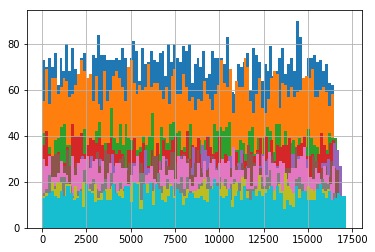

In [369]:
# посмотрим на топ 10 городов
for x in data['rivalry'].value_counts().iloc[0:10]:
    data['rank_stand'][data['rivalry'] == x].hist(bins=100)
plt.show()

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.

### Посмотрим распределение признака

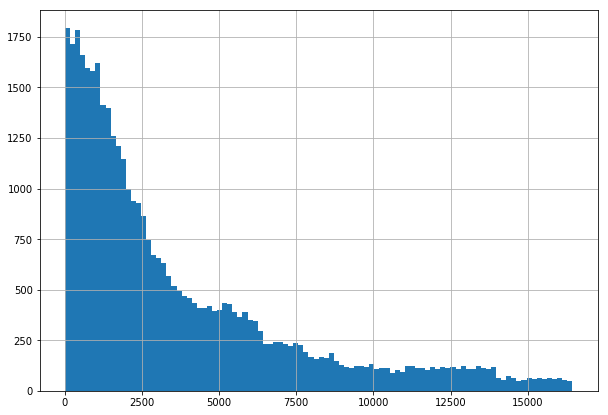

In [370]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

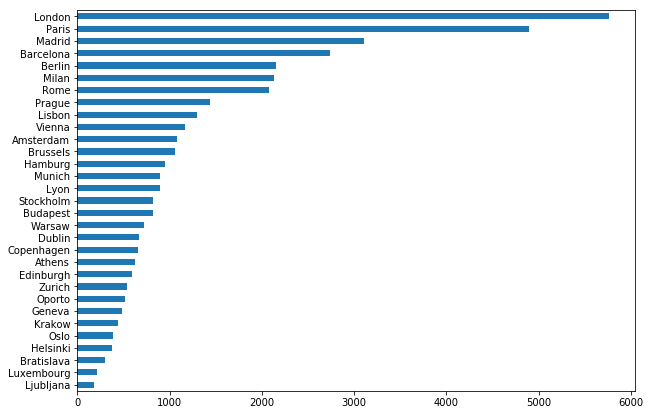

In [371]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

Посмотрим, как изменится распределение в большом городе:

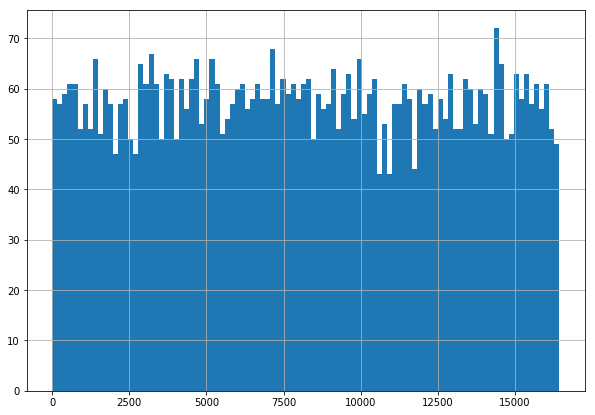

In [372]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

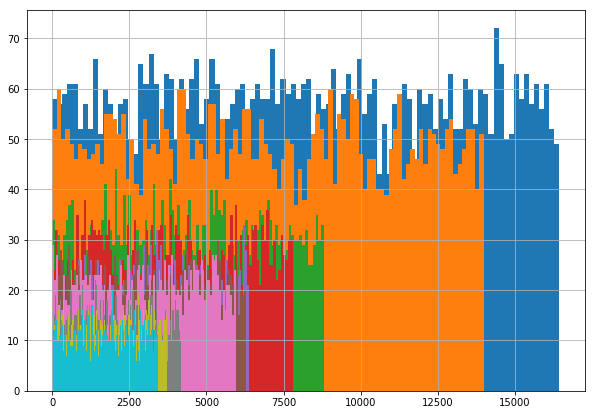

In [373]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

### Посмотрим распределение целевой переменной

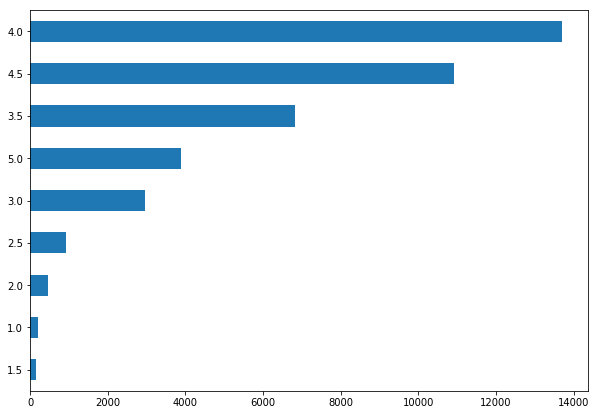

In [374]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

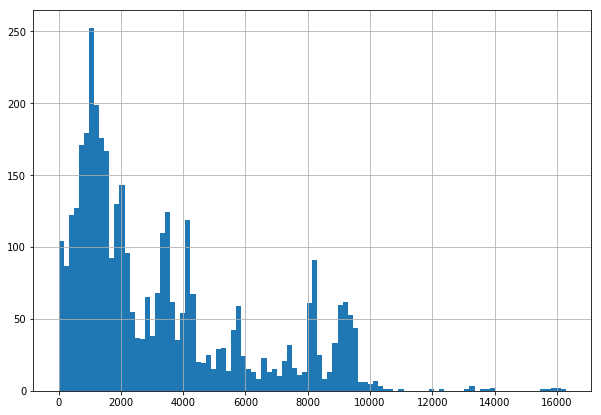

In [375]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

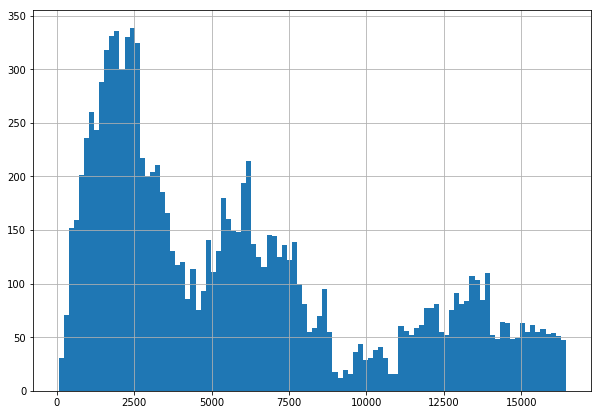

In [376]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### Рассмотрим [корреляцию признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас можно заметить, как признаки связаны между собой и с целевой переменной.

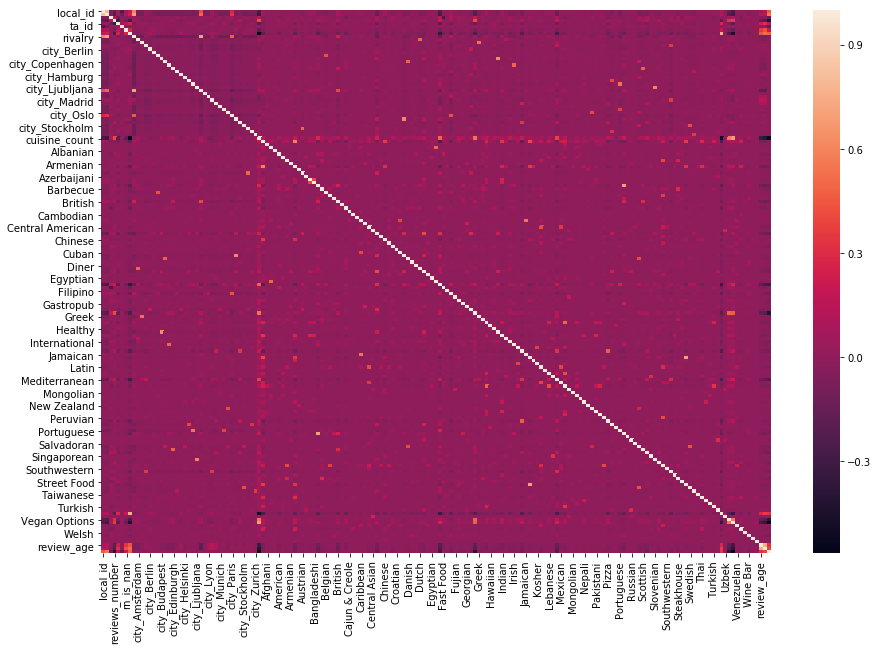

In [377]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr())

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [378]:
# На всякий случай заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [379]:
def is_exotic(tag_list):
    exotic = ['Japanese', 'Sushi', 'Asian', 'Thai', 'Vietnamese', 'Chinese', 'Mexican', 'Venezuelan',
          'South American', 'Latin', 'Argentinean', 'Central American', 'Indian', 'Turkish',
          'Pakistani', 'Peruvian', 'Tibetan', 'Nepali', 'Korean', 'Caribbean', 'Moroccan',
          'Halal', 'Lebanese', 'Russian', 'African', 'Ethiopian', 'Egyptian', 'Brazilian',
          'Ecuadorean', 'Israeli', 'Kosher', 'Australian', 'Singaporean', 'Malaysian',
          'Minority Chinese', 'Arabic', 'Ukrainian', 'Chilean', 'Mongolian', 'Cuban',
          'Persian', 'Indonesian', 'Colombian', 'Jamaican', 'Hawaiian', 'Armenian', 'Taiwanese',
          'Bangladeshi', 'Sri Lankan', 'Cambodian', 'Albanian', 'New Zealand', 'Central Asian',
          'Filipino', 'Tunisian', 'Cajun & Creole', 'Georgian', 'Polynesian', 'Azerbaijani',
          'Caucasian', 'Afghani', 'Uzbek', 'Salvadoran', 'Yunnan', 'Native American', 'Canadian',
          'Xinjiang', 'Burmese', 'Fujian']
    result = 0
    for tag in tag_list:
        if tag in exotic:
            result = 1
    return result



def review_age(dates):
    if len(dates) == 0:
        return 9999
    if len(dates) == 1:
        delta = datetime.today() - datetime.strptime(dates[0], '%m/%d/%Y')
        return delta.days
    if len(dates) == 2:       
        delta = datetime.today() - max(datetime.strptime(dates[0], '%m/%d/%Y'), datetime.strptime(dates[1], '%m/%d/%Y'))
        return delta.days    
    
    

def review_rate(dates):
    if len(dates) <= 1:
        return 9999
    if len(dates) == 2:
        delta = abs(datetime.strptime(dates[0], '%m/%d/%Y') - datetime.strptime(dates[1], '%m/%d/%Y'))
        return delta.days

    
    
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    
    df_output.columns = ['local_id', 'city', 'cuisine', 'ranking', 'prices', 'reviews_number', 'reviews', 'ta_url', 'ta_id', 'sample', 'rating']
    
    
    
    # ################### 2. NAN ############################################################## 
    
    # Начнём с reviews_number
    df_output['rn_is_nan'] = pd.isna(df_output['reviews_number']).astype('uint8')
    df_output['reviews_number'].fillna(df_output['reviews_number'].mean(), inplace=True)
    
    
    # Разберёмся с тегами, описывающими кухню заведения
    df_output['cuisine'].fillna("['Unknown']", inplace=True)
    
    
    # Не похоже, что 2 пустых значения колонки reviews значат что-то важное, заполним стандартным для этого признака образом
    df_output['reviews'].fillna('[[], []]', inplace=True)
    
    
    # Разберёмся с prices
    # Не очень понятно, будет ли это полезно, т.к. после замены на среднее бывшие значения NaN и так окажутся отделены от остальных значений prices, но...
    df_output['pr_is_nan'] = pd.isna(df_output['prices']).astype('uint8')
    
    
    # Согласно описанию, это данные о ценовой категории ресторана
    # У данных есть отношение порядка, так что заменим строковые данные на числовые
    # После чего в свою очередь можно будет заменить NaN на среднее значение

    df_output['prices'] = df_output['prices'].map({'$': 1, '$$ - $$$': 2.5, '$$$$': 4})
    df_output['prices'].fillna(df_output['prices'].mean(), inplace=True)
    
    
    
    # ################### 3. Encoding + Feature Engineering ############################################################## 
    
    # Разберёмся с city
    # До того, как get_dummies уничтожит изначальный столбец, вытащим из него дополнительный признак - количество конкурентов в городе
    cities_count = df_output['city'].value_counts()
    df_output['rivalry'] = df_output['city'].apply(lambda x: cities_count[x])
    
    # Используем One-Hot Encoding для категориального признака city
    df_output = pd.get_dummies(df_output, columns=['city'])
    
    
    # Обычно id не несёт полезной информации, но возможно в данном случае модель сможет получить какую-нибудь полезную информацию
    # Скажем, local_id может коррелировать с датой открытия ресторана, а этой информации в датасете нет
    df_output['local_id'] = df_output['local_id'].apply(lambda x: int(x[3:]))
    df_output['ta_id'] = df_output['ta_id'].apply(lambda x: int(x[1:]))
    
    
    # Разберёмся с cuisine
    # Приводим данные из плоского строкового формата в список строк
    df_output['cuisine'] = df_output['cuisine'].apply(lambda x: x[2:-2].split("', '"))

    # Заводим столбец с количеством тегов, описывающих кухню
    df_output['cuisine_count'] = df_output['cuisine'].apply(lambda x: len(x))
    
    # Заводим столбец с флагом, что кухня ресторана является экзотической / не европейской
    df_output['is_exotic'] = df_output['cuisine'].apply(is_exotic)
    
    # Склеиваем списки обратно в строку, чтобы затем воспользоваться str.get_dummies
    df_output['cuisine'] = df_output['cuisine'].str.join('|')
    
    # Используем One-Hot Encoding для категориального признака cuisine
    df_output = df_output.join(df_output['cuisine'].str.get_dummies(sep='|'))
    
    
    # Наконец, разбираемся с reviews
    # Вытаскиваем списки дат отзывов в отдельный столбец
    pattern = re.compile('\d{2}/\d{2}/\d{4}')
    df_output['reviews_dates'] = df_output['reviews'].apply(pattern.findall)
    
    # Создаём новый признак на основе отзывов - количество дней с последнего отзыва
    df_output['review_age'] = df_output['reviews_dates'].apply(review_age)
    
    # Создаём новый признак на основе отзывов - количество дней между последними отзывами
    df_output['review_rate'] = df_output['reviews_dates'].apply(review_rate)
    
    #!!!!!!
    df_output['rank_stand'] = df_output.rivalry.value_counts().iloc[0] * df_output['ranking']/df_output['rivalry']
    
    
    
    # ################### 4. Clean #################################################### 
    
    # убираем признаки которые еще не успели обработать, 
    # ta_url могла бы помочь для того, чтобы спарсить дополнительные данные, но я этого делать не умею, так что просто удалю
    df_output.drop(['ta_url'], axis=1, inplace=True)
    
    # Наконец, избавляемся от переиспользованных нечисловых признаков
    df_output.drop(['cuisine', 'reviews', 'reviews_dates'], axis=1, inplace=True)
    
    return df_output

#### Запускаем и проверяем, что получилось

In [380]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

,local_id,ranking,prices,reviews_number,ta_id,sample,rating,rn_is_nan,pr_is_nan,rivalry,...,Vegetarian Friendly,Venezuelan,Vietnamese,Welsh,Wine Bar,Xinjiang,Yunnan,review_age,review_rate,rank_stand
42379,8353,8354.0,2.222694,124.471197,5969402,1,5.0,1,1,6108,...,0,0,0,0,0,0,0,9999,9999,9837.970203
2765,2765,2414.0,2.222694,2.000000,5936110,0,0.0,0,1,1033,...,0,0,0,0,0,0,0,9999,9999,16809.198451
7028,7028,2146.0,2.500000,215.000000,718185,0,0.0,0,0,6108,...,0,0,0,0,0,0,0,1248,474,2527.206614
474,474,54.0,1.000000,426.000000,3936008,0,0.0,0,0,1145,...,1,0,0,0,0,0,0,1269,15,339.233188
22919,4997,4998.0,1.000000,34.000000,2643418,1,4.5,0,0,6108,...,0,0,0,0,0,0,0,1978,9999,5885.824165
18569,1582,1583.0,1.000000,70.000000,8790569,1,4.5,0,0,2589,...,1,0,0,0,0,0,0,1262,64,4398.037466
48901,10970,10980.0,2.222694,2.000000,8051516,1,4.5,0,1,7193,...,0,0,0,0,0,0,0,2132,7,10980.000000
11261,2057,2061.0,1.000000,102.000000,4326770,1,4.5,0,0,7193,...,1,0,0,0,0,0,0,1181,22,2061.000000
44687,5912,5914.0,2.222694,2.000000,4061718,1,3.0,0,1,2705,...,0,0,0,0,0,0,0,9999,9999,15726.211460
39060,8826,8828.0,2.222694,22.000000,3655809,1,4.5,0,1,6108,...,0,0,0,0,0,0,0,2831,9999,10396.169614


In [381]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 172 entries, local_id to rank_stand
dtypes: float64(5), int64(134), uint8(33)
memory usage: 54.6 MB


In [382]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.rating.values            # наш таргет
X = train_data.drop(['rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submission на kaggle.**

In [383]:
# Воспользуемся специальной функцией train_test_split для разбивки тестовых данных
# Выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [384]:
# Проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 171), (40000, 171), (40000, 170), (32000, 170), (8000, 170))

# Model 

In [385]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [386]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [387]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [388]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test) и смотрим, насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.19997375


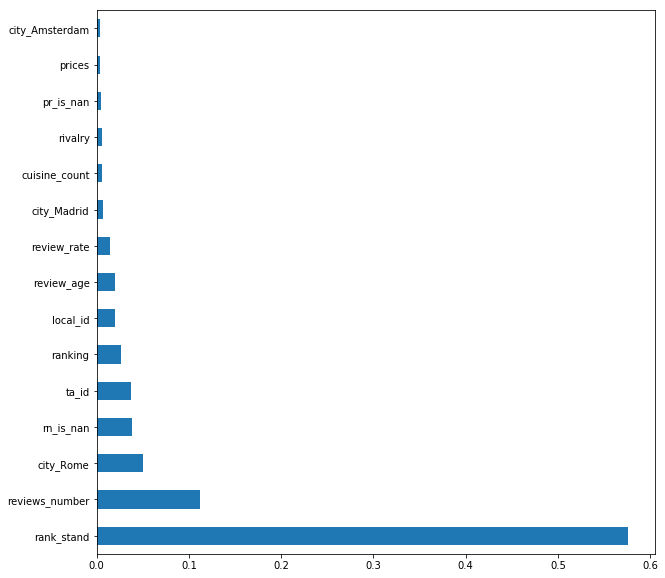

In [389]:
# В RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Выводы

Похоже, что основную пользу модели приносит параметр Ranking, стандартизированный относительно размеров гастрономической жизни города.

Довольно логичный результат, хотя и не очень ясно, что именно данный признак означает и из каких данных складывается (даже кажется, что они с рейтингом словно дублируют друг друга, а точнее, что ранкинг - это какая-то производная от рейтинга, т.е. они по определению должны коррелировать).

Неожиданно в пятёрке важных признаков обнаруживаются id ресторана в базе TripAdvisor (возможно это совпадение, а может быть от него зависит, скажем, насколько высоко ресторан оказывается в поисковых выборках на сайте) и отсутствие данных о количестве отзывов (может быть, это не ошибка в базе данных TA, а результат каких-то их санкций по отношению к обнаруженным махинациям с рейтингом). 

# Submission

In [390]:
test_data.sample(10)

,local_id,ranking,prices,reviews_number,ta_id,rating,rn_is_nan,pr_is_nan,rivalry,city_Amsterdam,...,Vegetarian Friendly,Venezuelan,Vietnamese,Welsh,Wine Bar,Xinjiang,Yunnan,review_age,review_rate,rank_stand
1791,1791,670.0,1.000000,89.0,6418624,0.0,0,0,1021,0,...,1,0,0,0,0,0,0,1198,332,4720.186092
4348,4348,6268.0,1.000000,4.0,10515312,0.0,0,0,3395,0,...,0,0,0,0,0,0,0,1415,3,13280.036524
9472,9472,5450.0,2.222694,20.0,987953,0.0,0,1,3813,0,...,0,0,0,0,0,0,0,2628,9999,10281.104117
67,67,225.0,2.500000,215.0,11857524,0.0,0,0,6108,0,...,0,0,0,0,0,0,0,1173,2,264.968075
9130,9130,141.0,2.500000,116.0,8757660,0.0,0,0,776,0,...,0,0,0,0,0,0,0,1188,0,1306.975515
1535,1535,4407.0,2.500000,15.0,12882421,0.0,0,0,3395,0,...,1,0,0,0,0,0,0,1202,27,9337.128424
7557,7557,4167.0,2.222694,3.0,11931931,0.0,0,1,2694,0,...,0,0,0,0,0,0,0,9999,9999,11125.920935
8628,8628,2954.0,2.500000,69.0,3742751,0.0,0,0,1314,0,...,0,0,0,0,0,0,0,1441,129,16170.564688
6639,6639,1235.0,2.222694,4.0,12833260,0.0,0,1,745,0,...,0,0,0,0,0,0,0,1236,64,11923.966443
7736,7736,1003.0,2.500000,61.0,3507122,0.0,0,0,1126,0,...,0,0,0,0,0,0,0,2808,9999,6407.263766


In [391]:
test_data = test_data.drop(['rating'], axis=1)

In [392]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [393]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [394]:
predict_submission

array([3.275, 4.225, 4.195, ..., 3.085, 4.475, 4.17 ])

In [395]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.275
1,id_1,4.225
2,id_2,4.195
3,id_3,4.345
4,id_4,4.400
5,id_5,4.455
6,id_6,2.915
7,id_7,2.040
8,id_8,4.005
9,id_9,4.580


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
